<a href="https://colab.research.google.com/github/sahararunner/DDMRP-Simulation/blob/main/DDMRP_Simulation_Model_(Updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

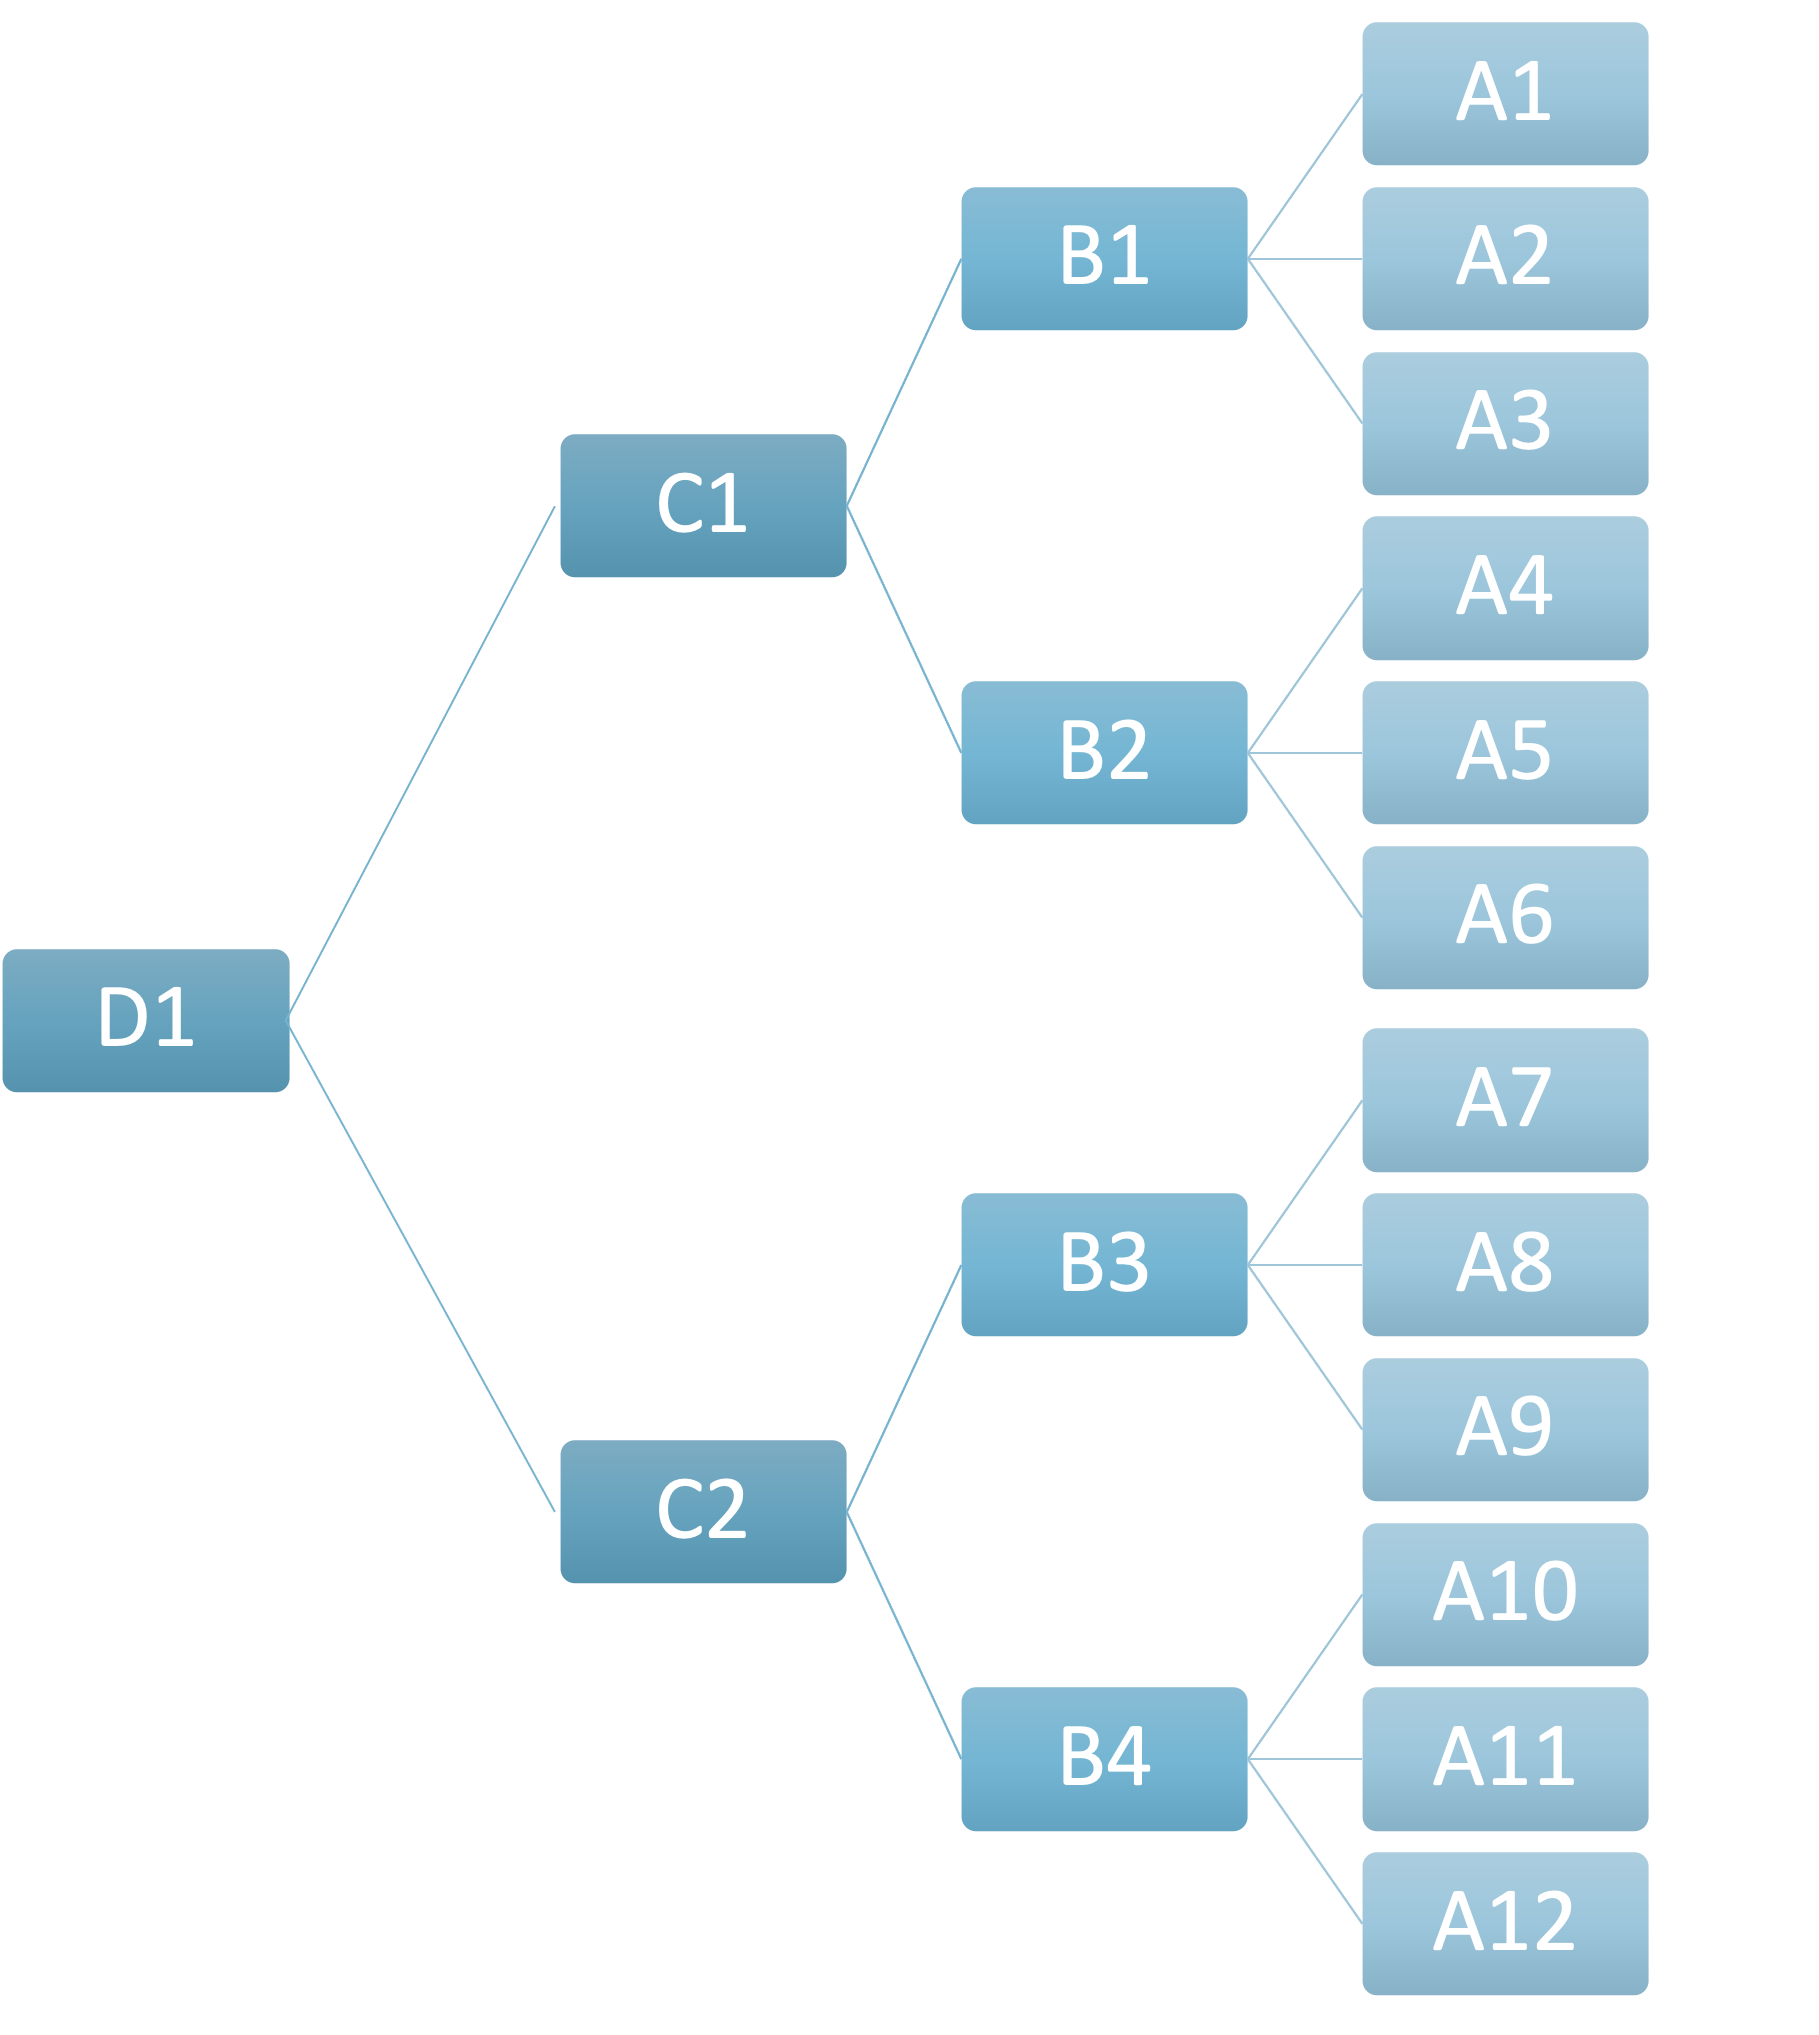

In [ ]:
globals().clear()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import time
from scipy.stats import norm as norm
from IPython.core.display import display_pretty
from statistics import mean
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
images_dir = '/content/gdrive/My Drive/DDMRP/'

Mounted at /content/gdrive


## **Model**

In [ ]:
class DDMRP():
    def __init__(self, time, ini_demand, ini_leadtime, ini_moq, ini_title, ini_onhand, ini_desiredorder, ini_ltadj):
        self.time = time 

        # Basic
        self.df1 = ini_demand #GSK
        self.ADU = 0
        self.ADUBackTrack = 10
        self.LT = ini_leadtime #GSK
        self.Lt_Adj = ini_ltadj #TBD
        self.Var_Adj= 1 #TBD
        self.MOQ = ini_moq #GSK
        self.batch = 1 #GSK
        self.title = ini_title
        self.desiredorder = ini_desiredorder #GSK
        self.daily_demand = 0
        self.ADUnow = 0

        # Stock Level
        self.OrderReceived = 0
        self.AvailableStock = 0

        # Order
        self.SuggestedOrder = 0 #$$$$$
        self.LastOrderTime = 0 #$$$$$
        
        # Traffic
        self.RedBase = 0
        self.RedSafety = 0
        self.TOR = 0
        self.TOY = 0
        self.TOG = 0

        # Records
        if self.time == startcuckoo:
          self.hist_time = []
          self.hist_demand = []
          self.hist_onhand = []
          self.hist_send = [] 
          self.hist_order = []
          self.hist_TOR = []
          self.hist_TOG = []
          self.hist_TOY = []
          self.stockout = 0
          self.NumOrder = 0
          self.hist_fillrate = []
          self.sg = {} # order log
          self.gh = {} # actual receive log
          for v in np.arange(self.time - self.LT, self.time + 1): #ini order/acutal receive log
            self.sg[v] = 0
            self.gh[v] = 0  
          self.OrderOnHand = ini_onhand
          self.OpenSupply = 0 #pipeline inventory
        else:
          self.hist_time = dic[(ini_title, cuckoo - 1)].hist_time
          self.hist_demand = dic[(ini_title, cuckoo - 1)].hist_demand
          self.hist_onhand = dic[(ini_title, cuckoo - 1)].hist_onhand
          self.hist_send = dic[(ini_title, cuckoo - 1)].hist_send
          self.hist_order = dic[(ini_title, cuckoo - 1)].hist_order
          self.hist_TOR = dic[(ini_title, cuckoo - 1)].hist_TOR
          self.hist_TOG = dic[(ini_title, cuckoo - 1)].hist_TOG
          self.hist_TOY = dic[(ini_title, cuckoo - 1)].hist_TOY
          self.stockout = dic[(ini_title, cuckoo - 1)].stockout
          self.hist_fillrate = dic[(ini_title, cuckoo - 1)].hist_fillrate  
          self.sg = dic[(ini_title, cuckoo - 1)].sg
          self.gh = dic[(ini_title, cuckoo - 1)].gh
          self.OrderOnHand = dic[(ini_title, cuckoo - 1)].OrderOnHand
          self.OpenSupply = dic[(ini_title, cuckoo - 1)].OpenSupply
          self.NumOrder = dic[(ini_title, cuckoo - 1)].NumOrder
        
    def generate_demand(self):
        demandgen = self.df1.iloc[self.time : self.time + 1].mean(axis=0)
        return demandgen

    def CalculateADU(self):
        if self.time < self.ADUBackTrack:
          ADU = self.df1.iloc[0 : self.time + 1].mean(axis=0)
        else: 
          ADU = self.df1.iloc[self.time - self.ADUBackTrack: self.time].mean(axis=0) 
        return ADU

    def simulate(self):
        self.daily_demand = self.generate_demand()[0]
        self.ADUnow = self.CalculateADU()[0]

        # Demand
        passed = self.time - self.LT
        self.OrderReceived = self.gh[passed]
        self.OpenSupply -= self.sg[passed]
        self.hist_order.append(self.OrderReceived)

        self.OrderOnHand = max(self.OrderOnHand - self.daily_demand + self.OrderReceived, 0)
        if self.OrderOnHand < self.daily_demand:
          self.stockout += 1
          self.hist_fillrate.append(self.OrderOnHand/self.daily_demand)
        else:
          self.hist_fillrate.append(1)
        self.AvailableStock = self.OrderOnHand + self.OpenSupply - self.daily_demand 

        # Traffic
        self.RedBase = self.LT * self.ADUnow * self.Lt_Adj
        self.RedSafety = self.RedBase * self.Var_Adj
        self.TOR = self.RedBase + self.RedSafety
        self.TOY = self.TOR + self.LT * self.ADUnow
        self.TOG = self.TOY + max(self.MOQ, self.LT * self.ADUnow * self.Lt_Adj, self.desiredorder * self.ADUnow)

        # Order
        if self.AvailableStock <= self.TOY:
          self.NumOrder += 1
          self.SuggestedOrder = max(self.MOQ, self.TOG - self.AvailableStock)
          self.hist_send.append(self.SuggestedOrder)
          self.OpenSupply += self.SuggestedOrder
          self.sg[self.time] = self.SuggestedOrder
          self.gh[self.time] = self.SuggestedOrder
        else:
          self.hist_send.append(0)
          self.sg[self.time] = 0
          self.gh[self.time] = 0

        # Record
        self.hist_time.append(self.time)
        self.hist_onhand.append(self.OrderOnHand)
        self.hist_demand.append(self.daily_demand)
        self.hist_TOR.append(self.TOR)
        self.hist_TOY.append(self.TOY)
        self.hist_TOG.append(self.TOG)
        
    def plot_inventorylevel(self):
        dd = plt.figure(self.title)
        plt.plot(self.hist_time, self.hist_demand, color = 'black', linewidth= 3)
        plt.plot(self.hist_time, self.hist_TOR, color = 'red')
        plt.plot(self.hist_time, self.hist_TOY, color = 'yellow')
        plt.plot(self.hist_time, self.hist_TOG, color = 'green')
        plt.plot(self.hist_time, self.hist_onhand, color = 'blue', linewidth= 3)
        plt.plot(self.hist_time, self.hist_order, color = 'brown', linewidth= 2)
        plt.plot(self.hist_time, self.hist_send, color = 'grey', linewidth= 2)

        plt.xticks(np.arange(self.hist_time[0], len(self.hist_time)+self.hist_time[0], 1))

        x = np.arange(len(self.hist_time))+self.hist_time[0]
        y1_red = np.array(self.hist_TOR)
        y1_yellow = np.array(self.hist_TOY)
        y1_green = np.array(self.hist_TOG)
        y2 = np.zeros(len(self.hist_time))

        plt.fill_between(x, y1_green, y2, color='green')
        plt.fill_between(x, y1_yellow, y2, color='yellow')
        plt.fill_between(x, y1_red, y2, color='red')

        plt.grid(True)
        plt.xlabel('nth month')
        plt.title(self.title)
        dd.show()

        fig = plt.gcf()
        fig.set_size_inches(30, 8)
        images_dir = '/content/gdrive/My Drive/DDMRP/'
        fig.savefig(f"{images_dir}"+self.title + ".png")

## **Level A**

In [ ]:
# Demand
A1_demand = pd.read_excel(images_dir + 'Demand Data/' +'C1.xlsx', header=None).iloc[0:71]
A2_demand = pd.read_excel(images_dir + 'Demand Data/' +'C2.xlsx', header=None).iloc[0:71]
A3_demand = pd.read_excel(images_dir + 'Demand Data/' +'C3.xlsx', header=None).iloc[0:71]
A4_demand = pd.read_excel(images_dir + 'Demand Data/' +'C4.xlsx', header=None).iloc[0:71]
A5_demand = pd.read_excel(images_dir + 'Demand Data/' +'C5.xlsx', header=None).iloc[0:71]
A6_demand = pd.read_excel(images_dir + 'Demand Data/' +'C6.xlsx', header=None).iloc[0:71]
A7_demand = pd.read_excel(images_dir + 'Demand Data/' +'C7.xlsx', header=None).iloc[0:71]
A8_demand = pd.read_excel(images_dir + 'Demand Data/' +'C8.xlsx', header=None).iloc[0:71]
A9_demand = pd.read_excel(images_dir + 'Demand Data/' +'C9.xlsx', header=None).iloc[0:71]
A10_demand = pd.read_excel(images_dir + 'Demand Data/' +'C10.xlsx', header=None).iloc[0:71]
A11_demand = pd.read_excel(images_dir + 'Demand Data/' +'C11.xlsx', header=None).iloc[0:71]
A12_demand = pd.read_excel(images_dir + 'Demand Data/' +'C12.xlsx', header=None).iloc[0:71]
  
# Leadtime
A_LT_default = 1
A1_LT = A_LT_default
A2_LT = A_LT_default
A3_LT = A_LT_default
A4_LT = A_LT_default
A5_LT = A_LT_default
A6_LT = A_LT_default
A7_LT = A_LT_default
A8_LT = A_LT_default
A9_LT = A_LT_default
A10_LT = A_LT_default
A11_LT = A_LT_default
A12_LT = A_LT_default

# MOQ
A_MOQ_default = 1000
A1_MOQ = A_MOQ_default
A2_MOQ = A_MOQ_default
A3_MOQ = A_MOQ_default
A4_MOQ = A_MOQ_default
A5_MOQ = A_MOQ_default
A6_MOQ = A_MOQ_default
A7_MOQ = A_MOQ_default
A8_MOQ = A_MOQ_default
A9_MOQ = A_MOQ_default
A10_MOQ = A_MOQ_default
A11_MOQ = A_MOQ_default
A12_MOQ = A_MOQ_default

# Title
A1_title = 'A1'
A2_title = 'A2'
A3_title = 'A3'
A4_title = 'A4'
A5_title = 'A5'
A6_title = 'A6'
A7_title = 'A7'
A8_title = 'A8'
A9_title = 'A9'
A10_title = 'A10'
A11_title = 'A11'
A12_title = 'A12'

# Order On Hand
A1_OrderOnHand = 5000
A2_OrderOnHand = 94000
A3_OrderOnHand = 216000
A4_OrderOnHand = 202000
A5_OrderOnHand = 68000
A6_OrderOnHand = 3000
A7_OrderOnHand = 87000
A8_OrderOnHand = 108000
A9_OrderOnHand = 77000
A10_OrderOnHand =78000
A11_OrderOnHand = 4000
A12_OrderOnHand = 103000

#Desired Order Frequency
A_desiredorder_default = 0.25
A1_desiredorder = A_desiredorder_default
A2_desiredorder = A_desiredorder_default
A3_desiredorder = A_desiredorder_default
A4_desiredorder = A_desiredorder_default
A5_desiredorder = A_desiredorder_default
A6_desiredorder = A_desiredorder_default
A7_desiredorder = A_desiredorder_default
A8_desiredorder = A_desiredorder_default
A9_desiredorder = A_desiredorder_default
A10_desiredorder = A_desiredorder_default
A11_desiredorder = A_desiredorder_default
A12_desiredorder = A_desiredorder_default

# Leadtime Adjust
A_LTAdj_default = 1
A1_LTAdj = A_LTAdj_default
A2_LTAdj = A_LTAdj_default
A3_LTAdj = A_LTAdj_default
A4_LTAdj = A_LTAdj_default
A5_LTAdj = A_LTAdj_default
A6_LTAdj = A_LTAdj_default
A7_LTAdj = A_LTAdj_default
A8_LTAdj = A_LTAdj_default
A9_LTAdj = A_LTAdj_default
A10_LTAdj = A_LTAdj_default
A11_LTAdj = A_LTAdj_default
A12_LTAdj = A_LTAdj_default

## **Level B**

In [ ]:
# Leadtime
B_LT_default = 2
B1_LT = B_LT_default
B2_LT = B_LT_default
B3_LT = B_LT_default
B4_LT = B_LT_default

# MOQ
B_MOQ_default = 2000
B1_MOQ = B_MOQ_default
B2_MOQ = B_MOQ_default
B3_MOQ = B_MOQ_default
B4_MOQ = B_MOQ_default

# Title
B1_title = 'B1'
B2_title = 'B2'
B3_title = 'B3'
B4_title = 'B4'

# Order On Hand
B1_OrderOnHand = 241300
B2_OrderOnHand = 300000
B3_OrderOnHand = 306700
B4_OrderOnHand = 256200

# Desired Order Frequency
B_desiredorder_default = 2
B1_desiredorder = B_desiredorder_default
B2_desiredorder = B_desiredorder_default
B3_desiredorder = B_desiredorder_default
B4_desiredorder = B_desiredorder_default

# Leadtime Adj
B_LTAdj_default = 0.7
B1_LTAdj = B_LTAdj_default
B2_LTAdj = B_LTAdj_default
B3_LTAdj = B_LTAdj_default
B4_LTAdj = B_LTAdj_default

## **Level C**

In [ ]:
C1_LT = 4
C2_LT = 4

C1_MOQ = 3000
C2_MOQ = 3000

C1_title = 'C1'
C2_title = 'C2'
    
C1_OrderOnHand = 5810000
C2_OrderOnHand = 1340000

C1_desiredorder = 2
C2_desiredorder = 2

C1_LTAdj = 0.5
C2_LTAdj = 0.5

## **Level D**

In [ ]:
D1_LT = 12
D1_MOQ = 3000
D1_title = 'D1'
D1_OrderOnHand = 10060000
D1_desiredorder = 3
D1_LTAdj = 0.2

## **Simulate**

In [ ]:
lis = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','B1','B2','B3','B4','C1','C2','D1']
lisA = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12']
lisB = ['B1','B2','B3','B4']
lisC = ['C1','C2']
lisD = ['D1']
dic = {}

startcuckoo = 0
cuckoo = startcuckoo
zero = pd.DataFrame(np.zeros((10, 1)))

# simulate
while cuckoo <= len(A1_demand) - 1:
  for i in lisA:
    dic[(i, cuckoo)] = DDMRP(cuckoo, globals()[i+"_demand"], globals()[i+"_LT"], globals()[i+"_MOQ"], globals()[i+"_title"], globals()[i+"_OrderOnHand"], globals()[i+"_desiredorder"], globals()[i+"_LTAdj"])
    dic[(i, cuckoo)].simulate()

  sumAforB1 = [a1 + a2 + a3 for a1, a2, a3 in zip(dic[('A1',cuckoo)].hist_send, dic[('A2',cuckoo)].hist_send, dic[('A3',cuckoo)].hist_send)] #B1
  sumAforB2 = [a4 + a5 + a6 for a4, a5, a6 in zip(dic[('A4',cuckoo)].hist_send, dic[('A5',cuckoo)].hist_send, dic[('A6',cuckoo)].hist_send)] #B2
  sumAforB3 = [a7 + a8 + a9 for a7, a8, a9 in zip(dic[('A7',cuckoo)].hist_send, dic[('A8',cuckoo)].hist_send, dic[('A9',cuckoo)].hist_send)] #B3
  sumAforB4 = [a10 + a11 + a12 for a10, a11, a12 in zip(dic[('A10',cuckoo)].hist_send, dic[('A11',cuckoo)].hist_send, dic[('A12',cuckoo)].hist_send)] #B4
  B1_demand = zero.append(pd.DataFrame(sumAforB1))
  B2_demand = zero.append(pd.DataFrame(sumAforB2))
  B3_demand = zero.append(pd.DataFrame(sumAforB3))
  B4_demand = zero.append(pd.DataFrame(sumAforB4))

  for i in lisB:
    dic[(i, cuckoo)] = DDMRP(cuckoo, globals()[i+"_demand"], globals()[i+"_LT"], globals()[i+"_MOQ"], globals()[i+"_title"], globals()[i+"_OrderOnHand"], globals()[i+"_desiredorder"], globals()[i+"_LTAdj"])
    dic[(i, cuckoo)].simulate()
  
  # adjust for back order
  dic[('A1', cuckoo)].gh[cuckoo] = min(dic[('B1', cuckoo)].OrderOnHand/(dic[('B1', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A1', cuckoo)].gh[cuckoo]
  dic[('A2', cuckoo)].gh[cuckoo] = min(dic[('B1', cuckoo)].OrderOnHand/(dic[('B1', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A2', cuckoo)].gh[cuckoo]
  dic[('A3', cuckoo)].gh[cuckoo] = min(dic[('B1', cuckoo)].OrderOnHand/(dic[('B1', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A3', cuckoo)].gh[cuckoo]
  dic[('A4', cuckoo)].gh[cuckoo] = min(dic[('B2', cuckoo)].OrderOnHand/(dic[('B2', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A4', cuckoo)].gh[cuckoo]
  dic[('A5', cuckoo)].gh[cuckoo] = min(dic[('B2', cuckoo)].OrderOnHand/(dic[('B2', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A5', cuckoo)].gh[cuckoo]
  dic[('A6', cuckoo)].gh[cuckoo] = min(dic[('B2', cuckoo)].OrderOnHand/(dic[('B2', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A6', cuckoo)].gh[cuckoo]
  dic[('A7', cuckoo)].gh[cuckoo] = min(dic[('B3', cuckoo)].OrderOnHand/(dic[('B3', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A7', cuckoo)].gh[cuckoo]
  dic[('A8', cuckoo)].gh[cuckoo] = min(dic[('B3', cuckoo)].OrderOnHand/(dic[('B3', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A8', cuckoo)].gh[cuckoo]
  dic[('A9', cuckoo)].gh[cuckoo] = min(dic[('B3', cuckoo)].OrderOnHand/(dic[('B3', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A9', cuckoo)].gh[cuckoo]
  dic[('A10', cuckoo)].gh[cuckoo] = min(dic[('B4', cuckoo)].OrderOnHand/(dic[('B4', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A10', cuckoo)].gh[cuckoo]
  dic[('A11', cuckoo)].gh[cuckoo] = min(dic[('B4', cuckoo)].OrderOnHand/(dic[('B4', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A11', cuckoo)].gh[cuckoo]
  dic[('A12', cuckoo)].gh[cuckoo] = min(dic[('B4', cuckoo)].OrderOnHand/(dic[('B4', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('A12', cuckoo)].gh[cuckoo]

  sumBforC1 = [b1 + b2 for b1, b2 in zip(dic[('B1',cuckoo)].hist_send, dic[('B2',cuckoo)].hist_send)] #C1
  sumBforC2 = [b3 + b4 for b3, b4 in zip(dic[('B3',cuckoo)].hist_send, dic[('B4',cuckoo)].hist_send)] #C2
  C1_demand = zero.append(pd.DataFrame(sumBforC1))
  C2_demand = zero.append(pd.DataFrame(sumBforC2))

  for i in lisC:
    dic[(i, cuckoo)] = DDMRP(cuckoo, globals()[i+"_demand"], globals()[i+"_LT"], globals()[i+"_MOQ"], globals()[i+"_title"], globals()[i+"_OrderOnHand"], globals()[i+"_desiredorder"], globals()[i+"_LTAdj"])
    dic[(i, cuckoo)].simulate()

  # adjust for back order
  if cuckoo > 20:
    dic[('B1', cuckoo)].gh[cuckoo] = min(dic[('C1', cuckoo)].OrderOnHand/(dic[('C1', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('B1', cuckoo)].gh[cuckoo]
    dic[('B2', cuckoo)].gh[cuckoo] = min(dic[('C1', cuckoo)].OrderOnHand/(dic[('C1', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('B2', cuckoo)].gh[cuckoo]
    dic[('B3', cuckoo)].gh[cuckoo] = min(dic[('C2', cuckoo)].OrderOnHand/(dic[('C2', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('B3', cuckoo)].gh[cuckoo]
    dic[('B4', cuckoo)].gh[cuckoo] = min(dic[('C2', cuckoo)].OrderOnHand/(dic[('C2', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('B4', cuckoo)].gh[cuckoo]

  sumCforD1 = [c1 + c2 for c1, c2 in zip(dic[('C1',cuckoo)].hist_send, dic[('C2',cuckoo)].hist_send)] #D1
  D1_demand = zero.append(pd.DataFrame(sumCforD1))

  for i in lisD:
    dic[(i, cuckoo)] = DDMRP(cuckoo, globals()[i+"_demand"], globals()[i+"_LT"], globals()[i+"_MOQ"], globals()[i+"_title"], globals()[i+"_OrderOnHand"], globals()[i+"_desiredorder"], globals()[i+"_LTAdj"])
    dic[(i, cuckoo)].simulate()

  # adjust for back order
  if cuckoo > 30:
    dic[('C1', cuckoo)].gh[cuckoo] = min(dic[('D1', cuckoo)].OrderOnHand/(dic[('D1', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('C1', cuckoo)].gh[cuckoo]
    dic[('C2', cuckoo)].gh[cuckoo] = min(dic[('D1', cuckoo)].OrderOnHand/(dic[('D1', cuckoo)].daily_demand + 0.0000000001), 1) * dic[('C2', cuckoo)].gh[cuckoo]

  cuckoo += 1

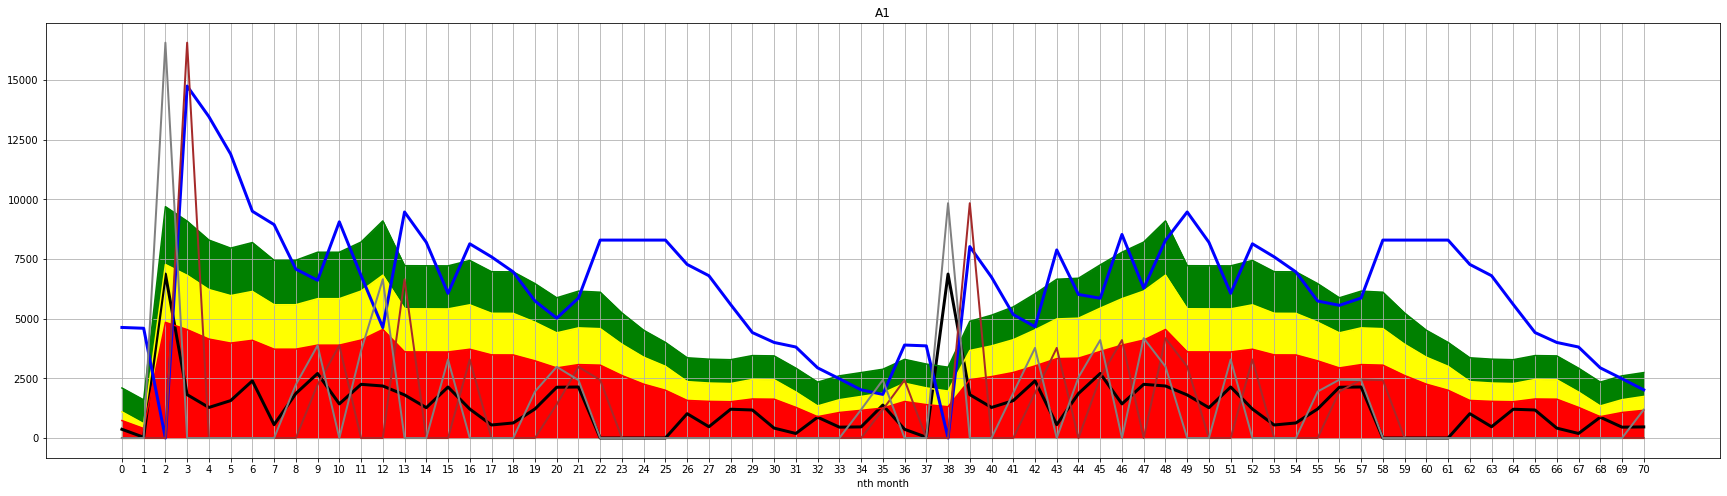

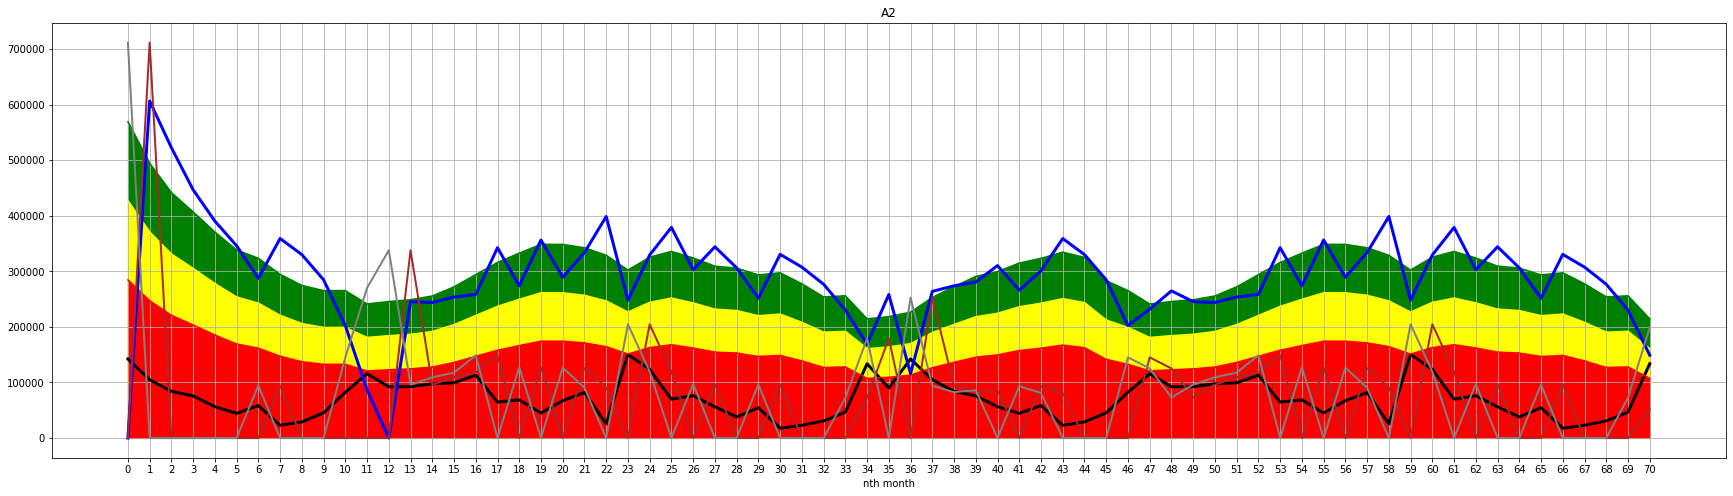

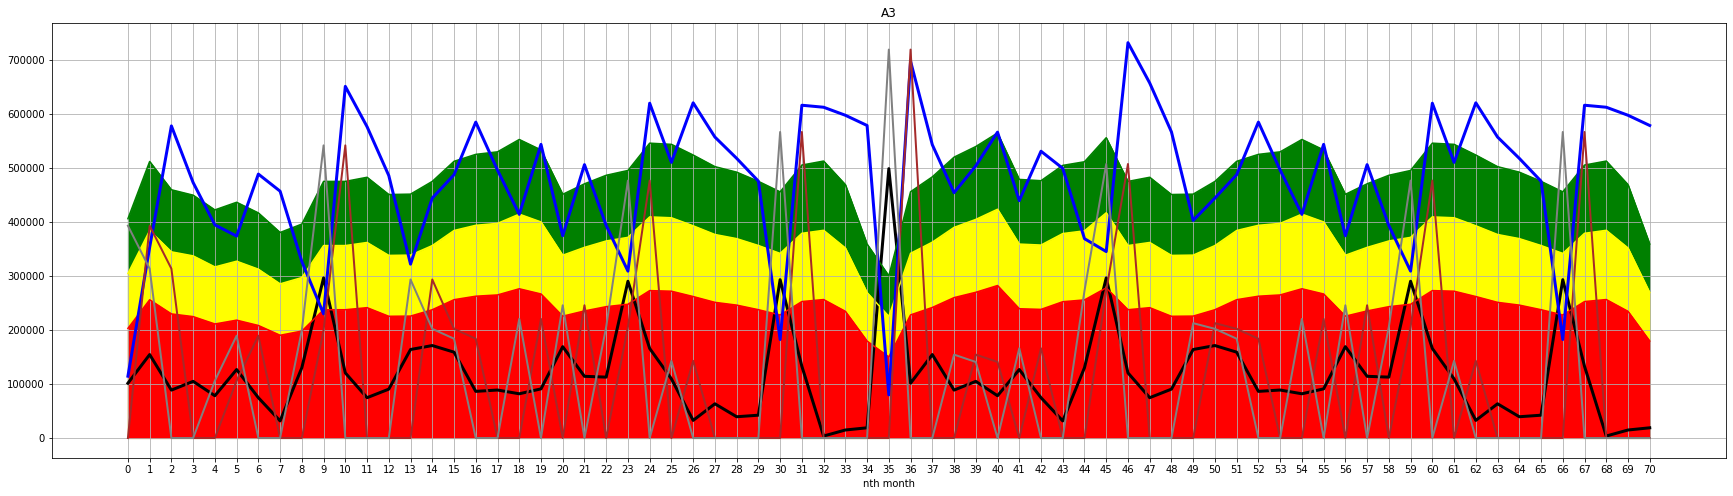

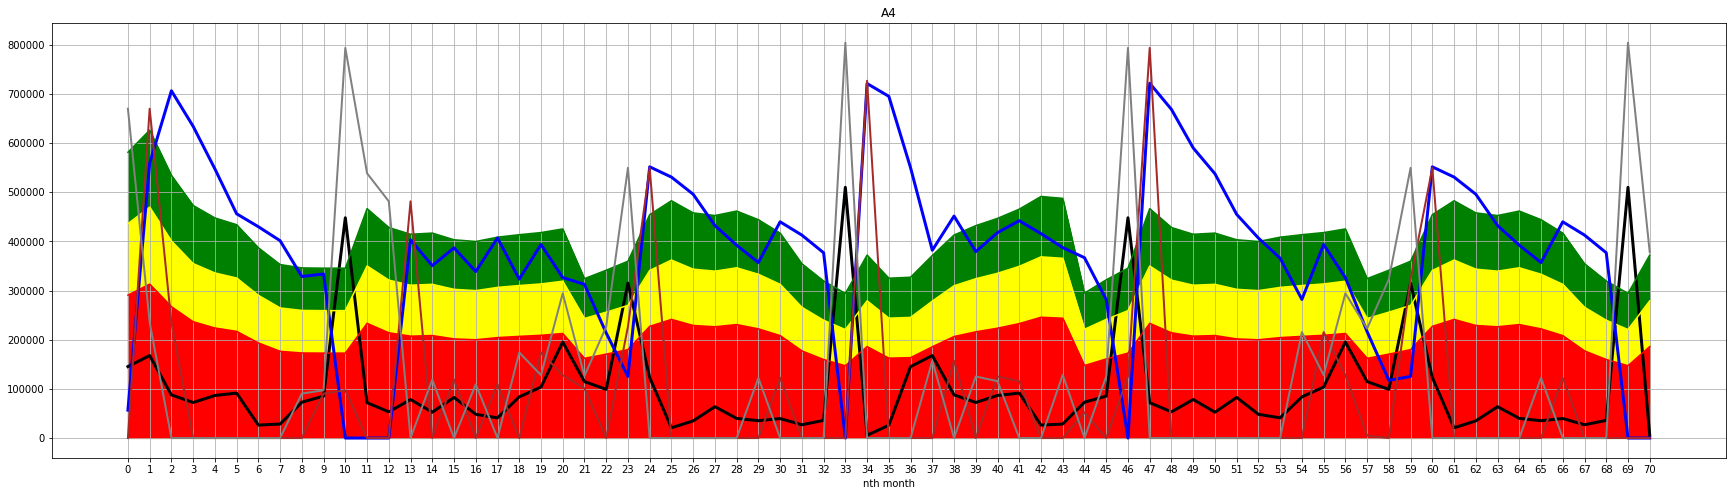

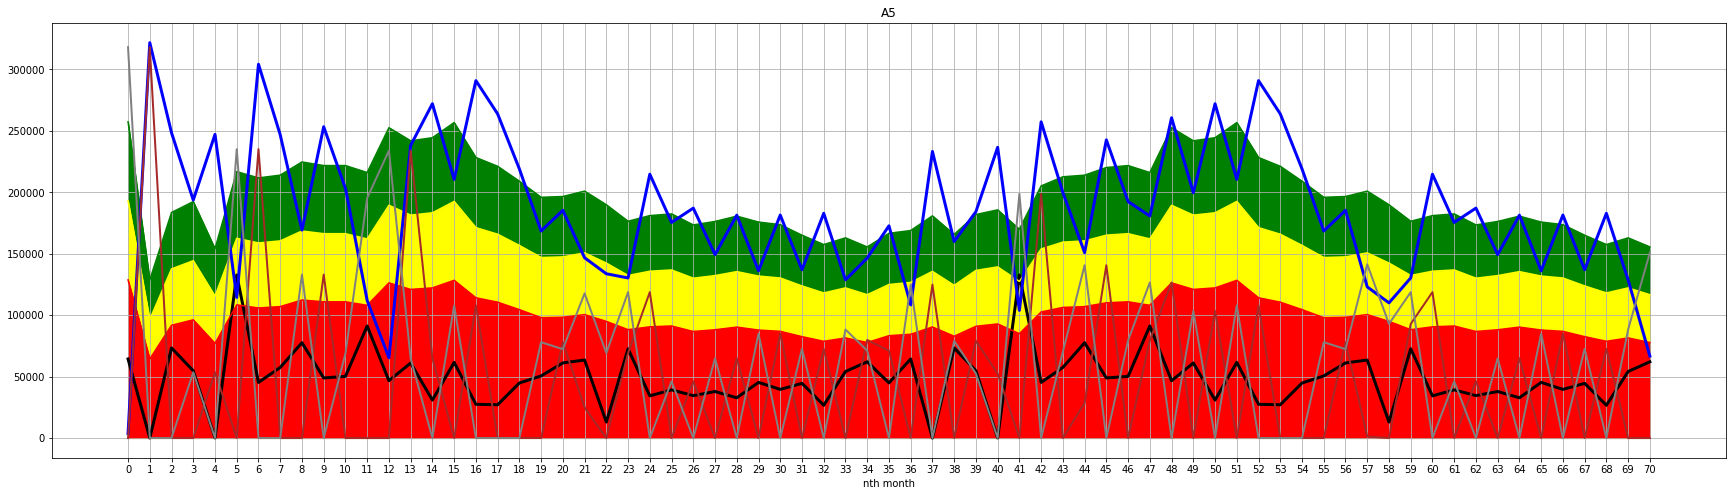

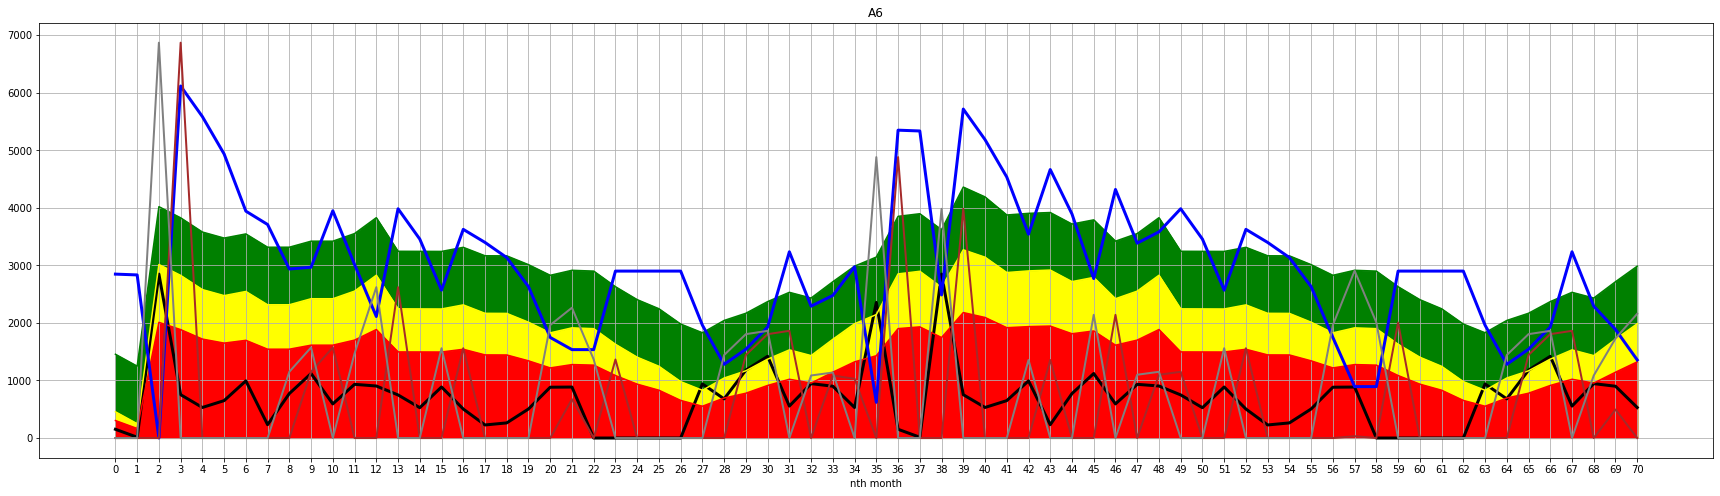

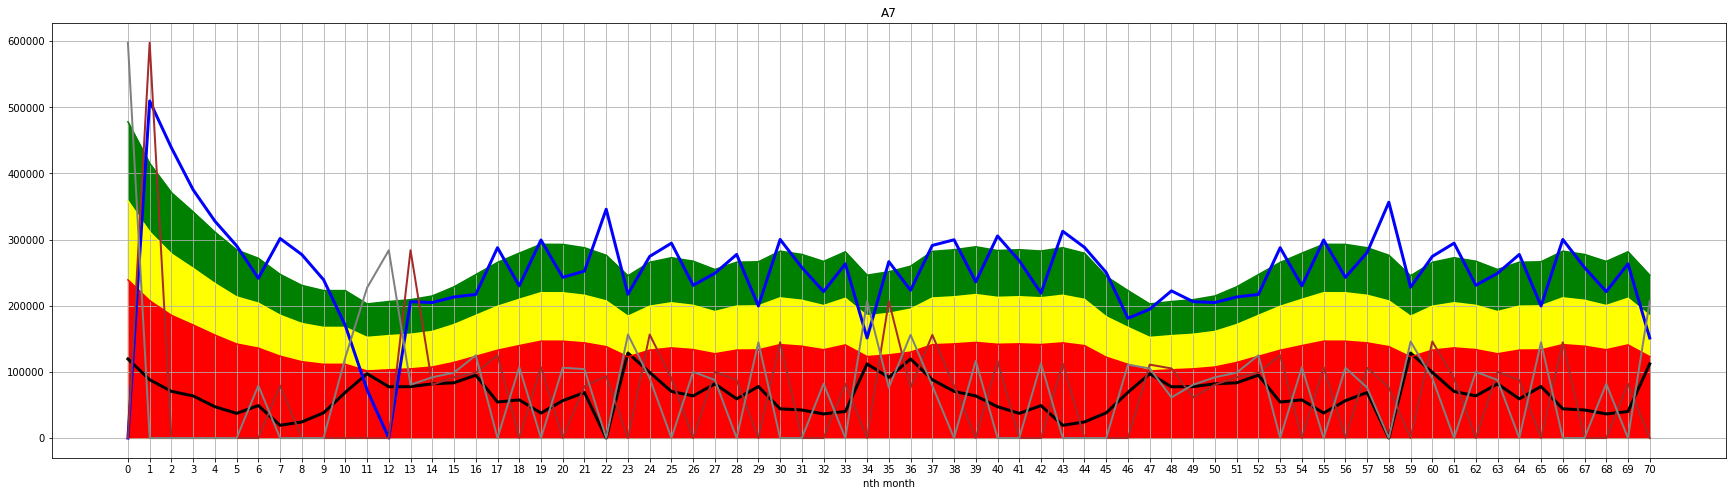

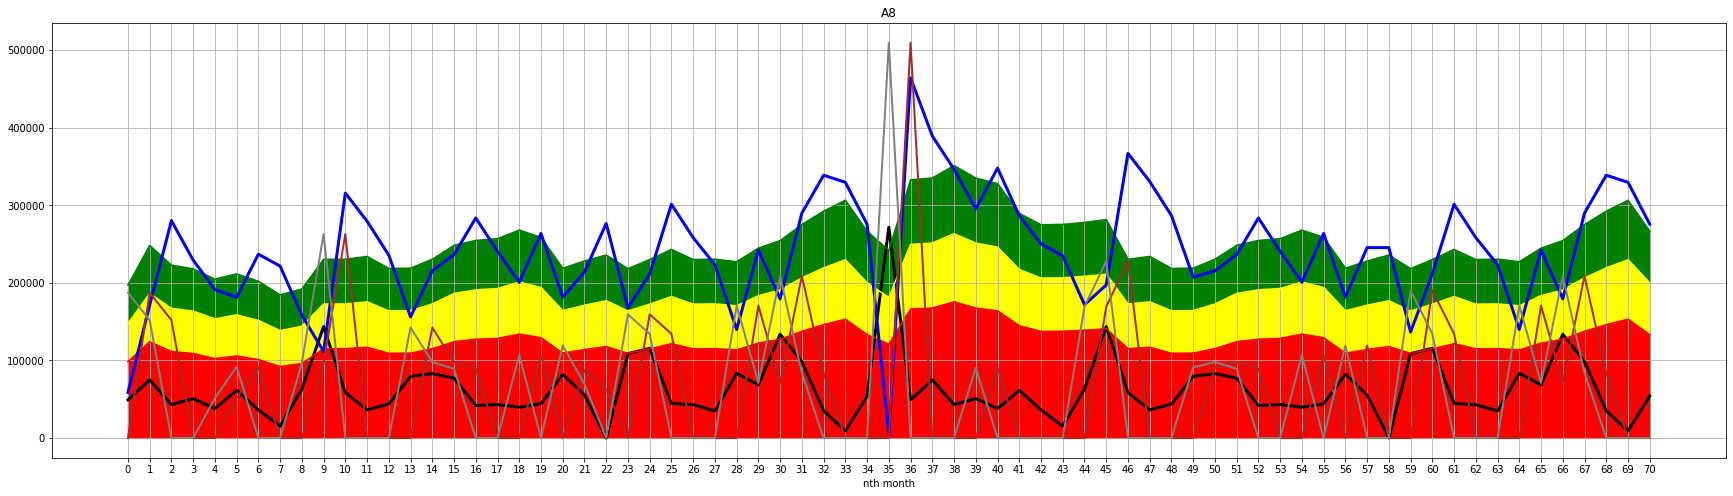

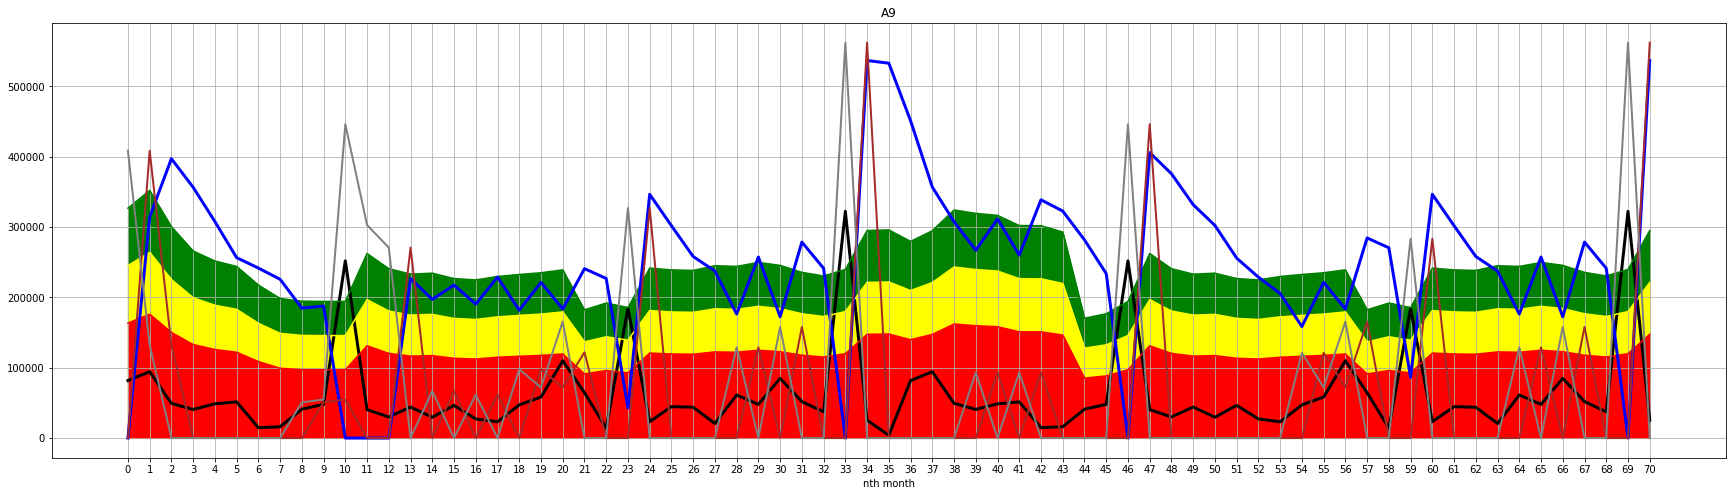

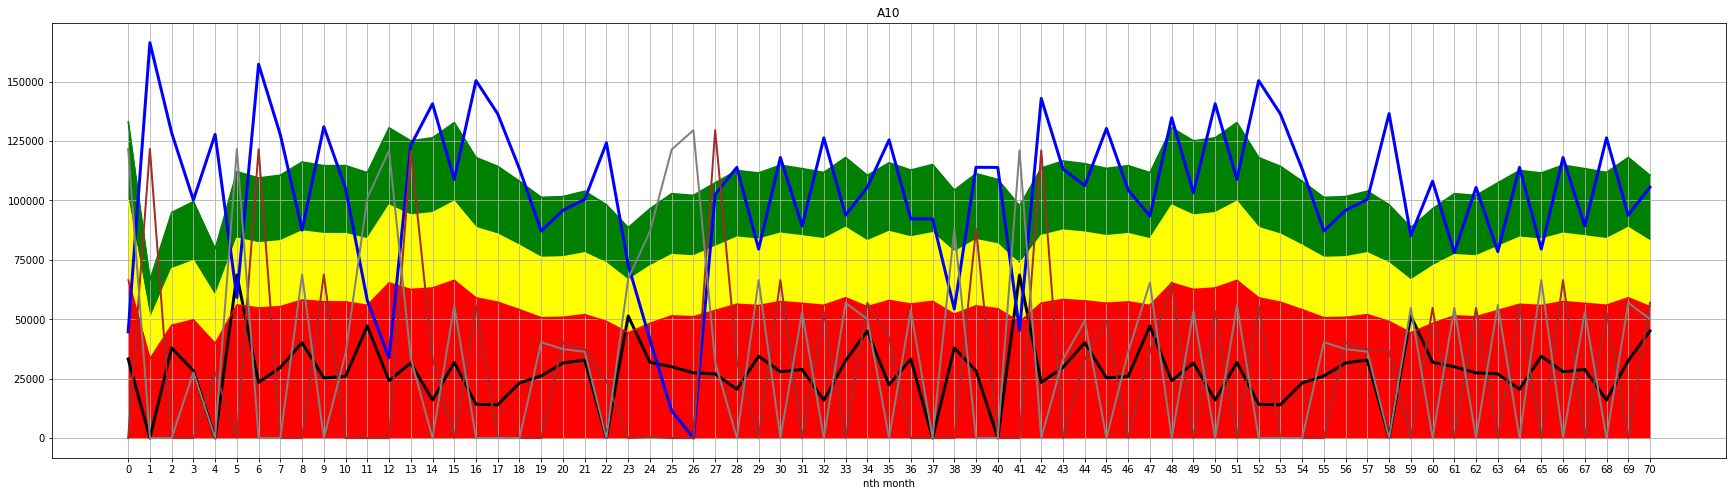

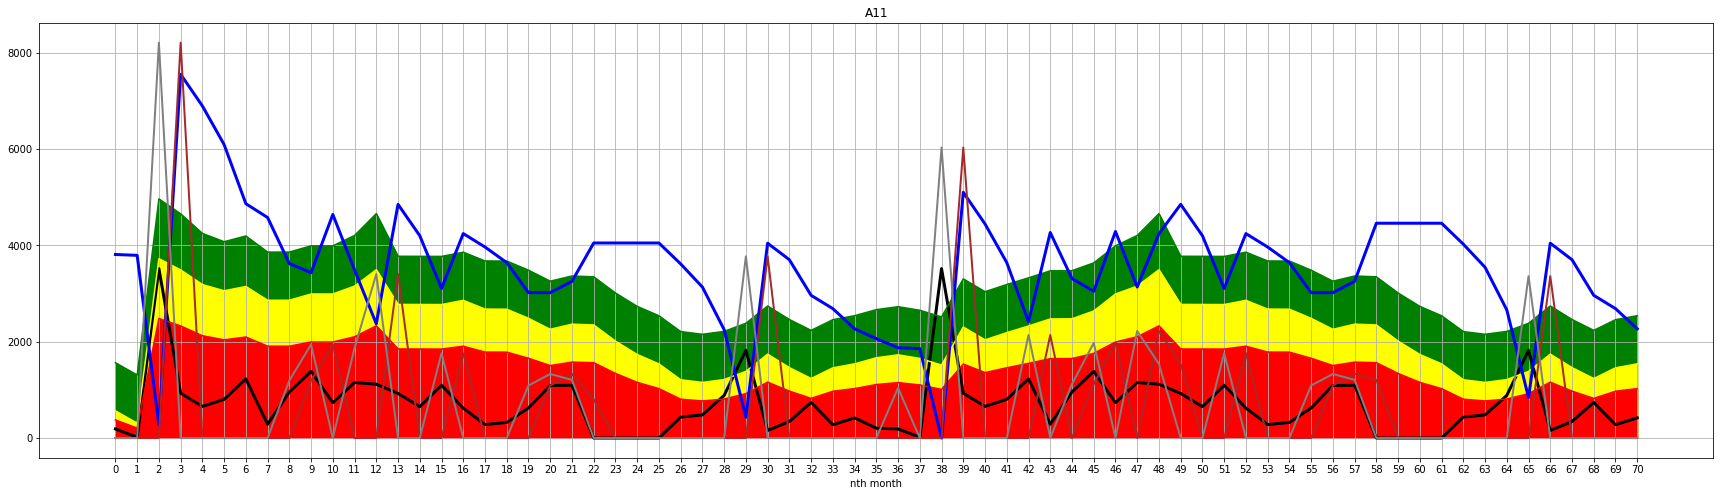

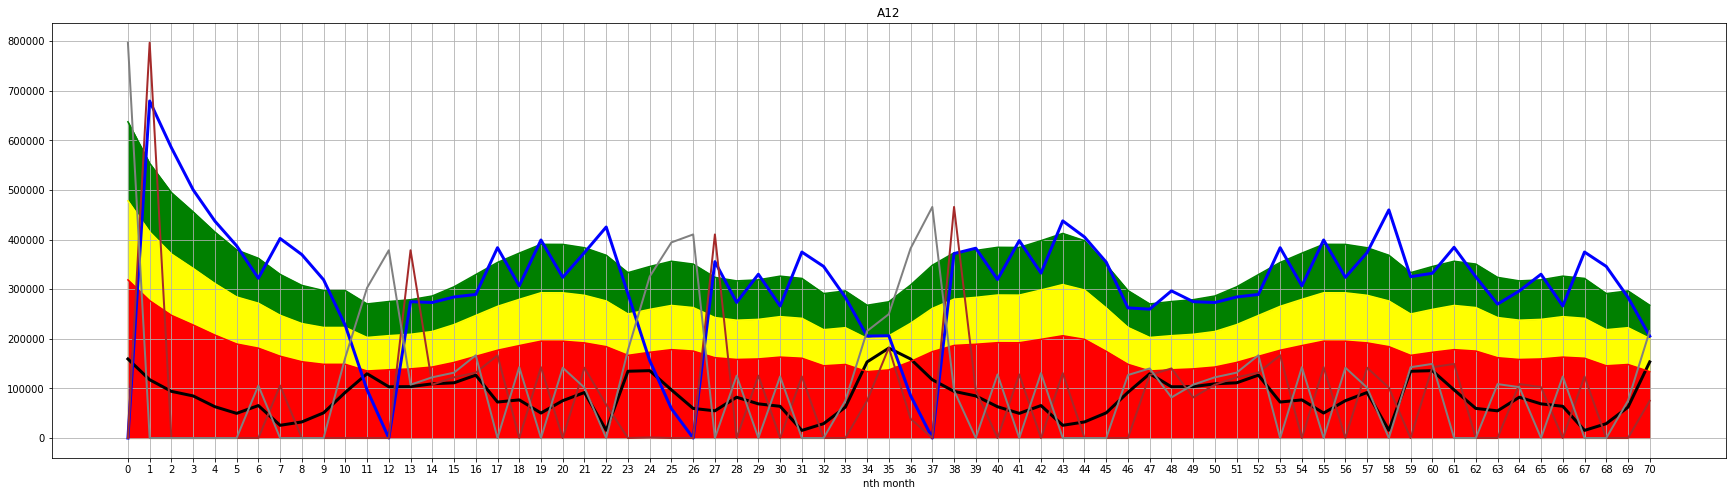

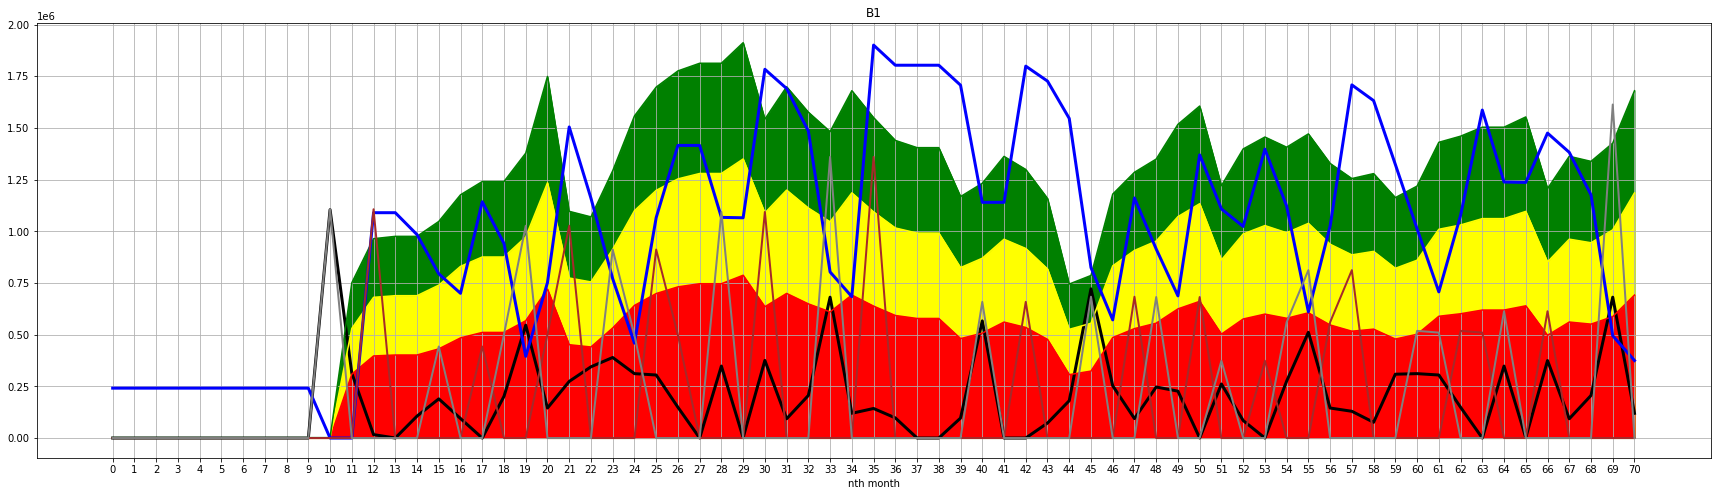

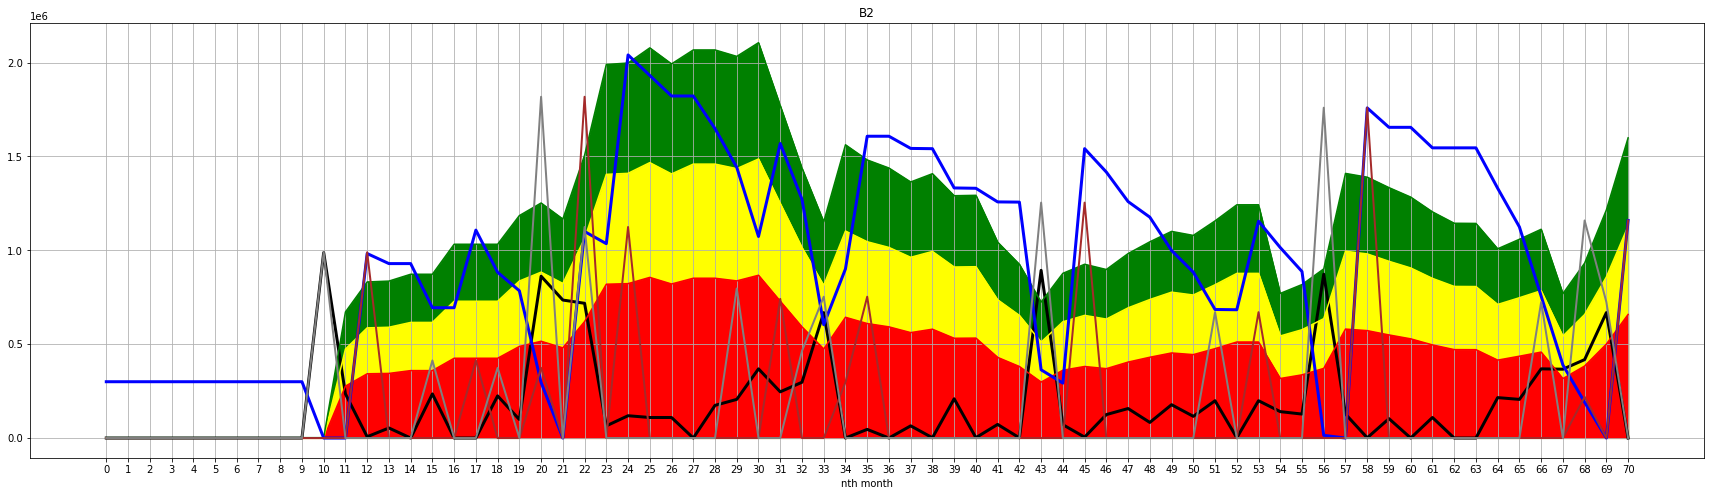

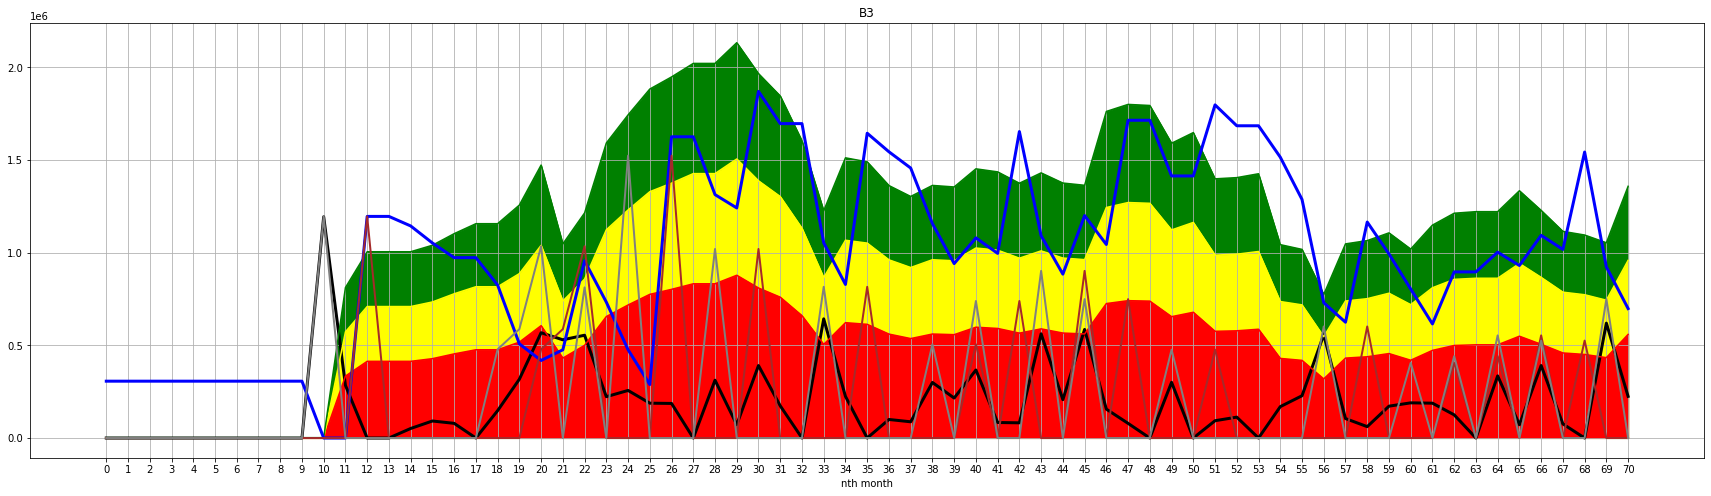

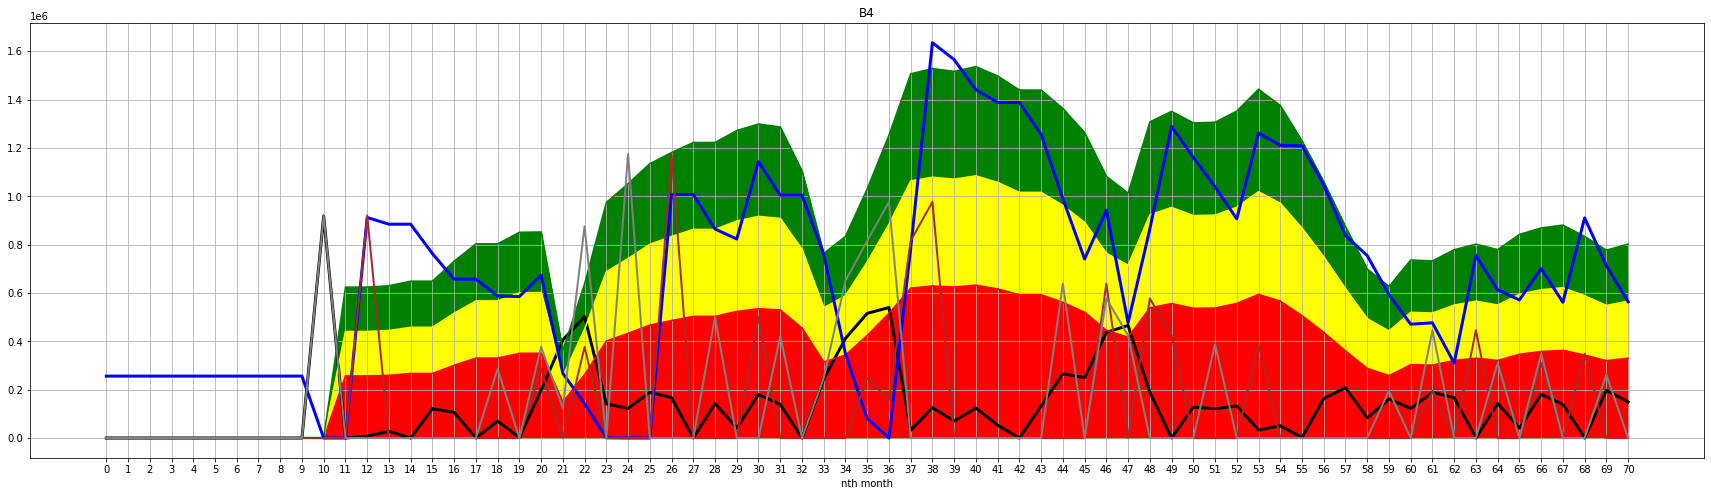

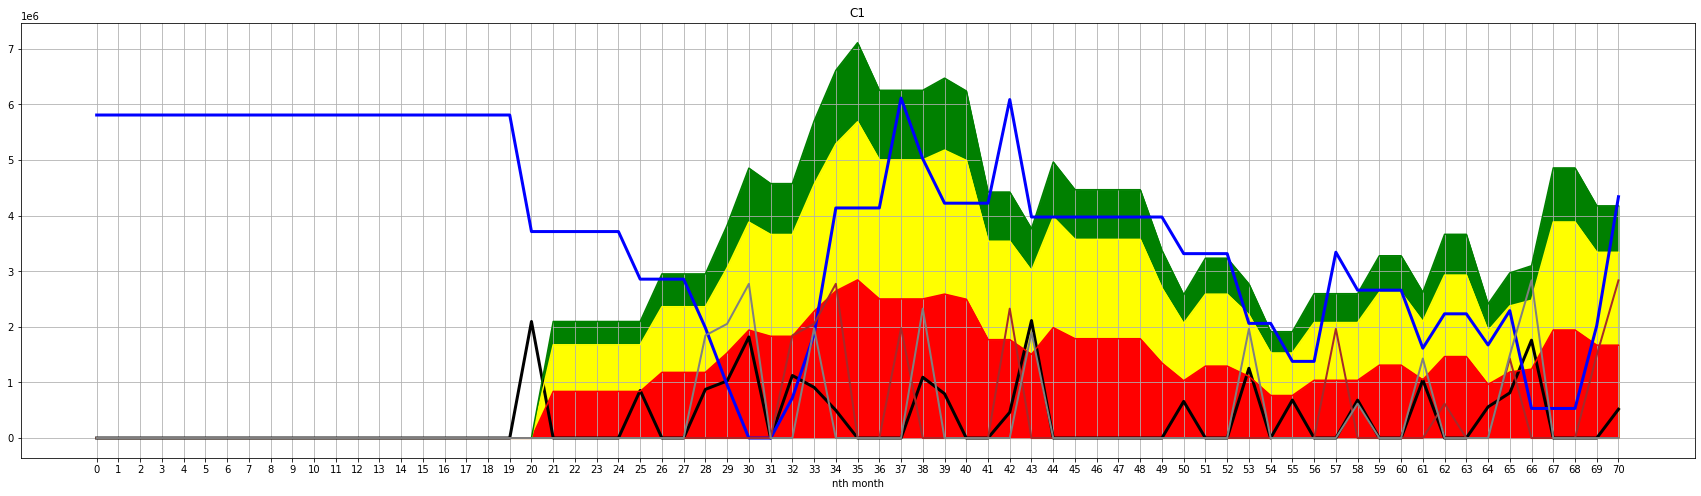

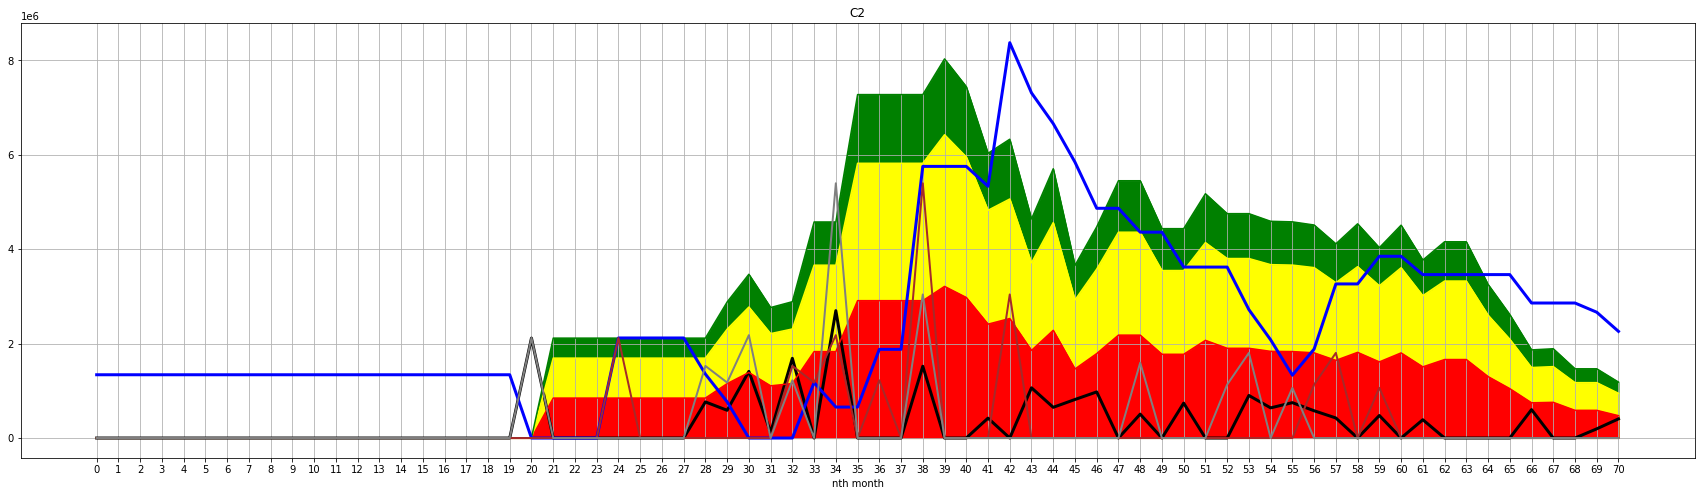

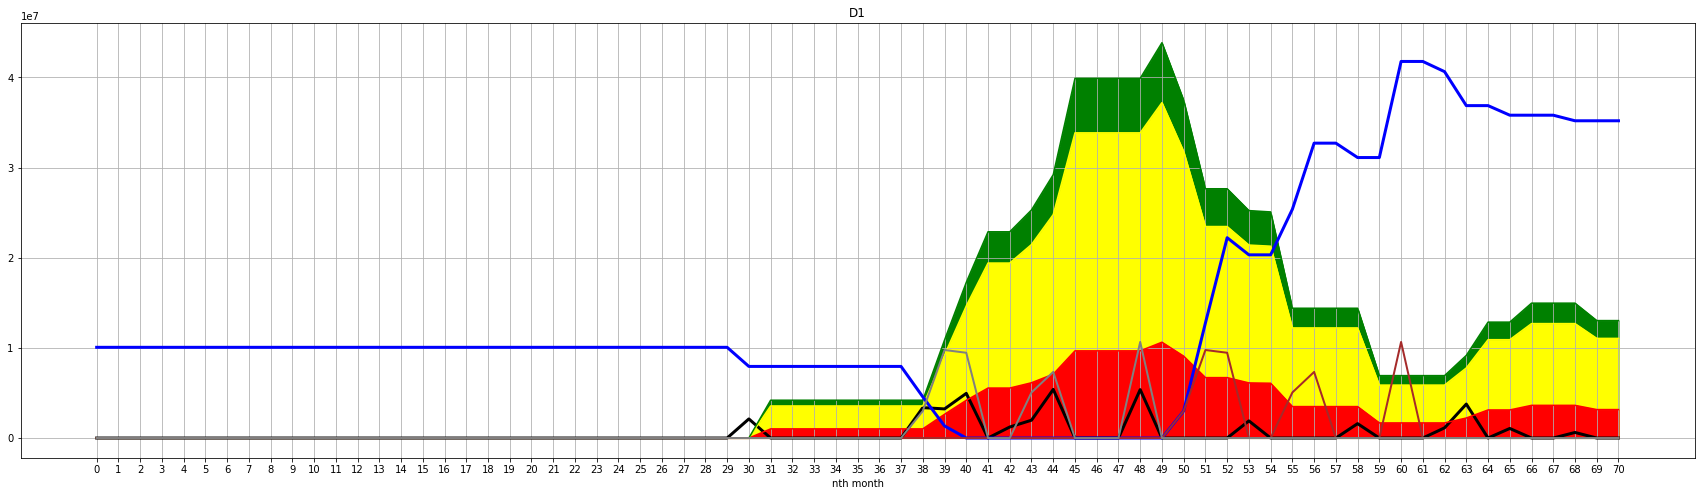

In [ ]:
# graph
for y in lis:
  dic[(y, cuckoo -1)].plot_inventorylevel()

In [ ]:
# Table
from tabulate import tabulate

# A = len(A1_demand) - startcuckoo * 0 
# B = len(A1_demand) - startcuckoo * 1 
# C = len(A1_demand) - startcuckoo * 2 
# D = len(A1_demand) - startcuckoo * 3 

mydata =[]
for i in lis:
  mydata.append([i, 
                 globals()[i+"_demand"][0].mean(),
                 globals()[i+"_demand"][0].std()/(globals()[i+"_demand"][0].mean()+0.000000001),
                 globals()[i+"_OrderOnHand"],
                 globals()[i+"_LT"],
                 globals()[i+"_MOQ"], 
                 globals()[i+"_desiredorder"],
                 mean(dic[(i, cuckoo-1)].hist_onhand),
                 dic[(i, cuckoo-1)].NumOrder, 
                 dic[(i, cuckoo-1)].stockout, 
                 mean(dic[(i, cuckoo-1)].hist_fillrate)
                 ])
  
head = ["Node", "Avg Demand", "Norm Std Demand", "Initial Onhand", "Lead Time (Month)", "MOQ", "Desired Order Freq (Month)", "Avg Onhand", "Order Freq (Month)", "Num of Stockout", "Fill Rate"]
print(tabulate(mydata, headers=head, tablefmt="grid")) 

mydata = pd.DataFrame(mydata)
mydata.to_excel('Output.xlsx')

+--------+--------------+-------------------+------------------+---------------------+-------+------------------------------+------------------+----------------------+-------------------+-------------+
| Node   |   Avg Demand |   Norm Std Demand |   Initial Onhand |   Lead Time (Month) |   MOQ |   Desired Order Freq (Month) |       Avg Onhand |   Order Freq (Month) |   Num of Stockout |   Fill Rate |
+========+==============+===================+==================+=====================+=======+==============================+==================+======================+===================+=============+
| A1     |     1278.7   |          0.972494 |             5000 |                   1 |  1000 |                         0.25 |   6348.99        |                   23 |                 2 |    0.971831 |
+--------+--------------+-------------------+------------------+---------------------+-------+------------------------------+------------------+----------------------+-------------------+-----